# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

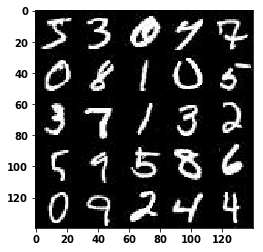

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

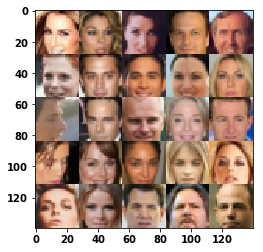

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.2, dropout=0.4):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        ## Added xavier_initializer() to conv2d kernel initializer
        ## Dropouts also added after leaky relu
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, dropout)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, dropout)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, dropout)
        
        ## Additional layer
        x4 = tf.layers.conv2d(x2, 512, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4, dropout)
        
        flat = tf.reshape(x4, (-1, 4*4*128))
        
        logits = tf.layers.dense(flat, 1)
        output = tf.nn.sigmoid(logits)
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.2, dropout=0.4):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        ## More noise, as per /soumith/ganhacks
        x1 = tf.layers.dropout(x1, dropout)
        ##
        
        # To 7, 7, 256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 14, 14, 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # 28, 28, output
        # Had to add an additional conv2d_transpose otherwise Gen loss was always too high
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        x5 = tf.layers.conv2d_transpose(x4, 32, 5, strides=1, padding='same')
        x5 = tf.layers.batch_normalization(x4, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
            
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, alpha = alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=20,
         show_every=80):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _, img_width, img_height, img_chn = data_shape
    
    input_real, input_z, learn_rate = model_inputs(img_width, img_height, img_chn, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, img_chn)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    losses = []
    n_images = 20
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                ## Recommended tweak
                batch_images *= 2
                
                # Random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizer                
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images,
                                                       input_z: batch_z,
                                                       learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images,
                                                       input_z: batch_z,
                                                       learn_rate: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_chn, data_image_mode)
                    
                # TODO: Train Model

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 1.1343
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 1.3767
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.7201
Epoch 1/2... Discriminator Loss: 0.5145... Generator Loss: 1.9048


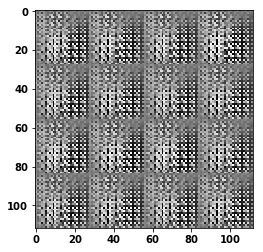

Epoch 1/2... Discriminator Loss: 0.4649... Generator Loss: 2.0376
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 2.5181
Epoch 1/2... Discriminator Loss: 0.2685... Generator Loss: 2.7267
Epoch 1/2... Discriminator Loss: 1.3007... Generator Loss: 0.9113


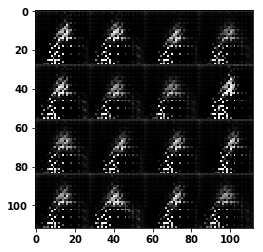

Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.3459... Generator Loss: 0.8777


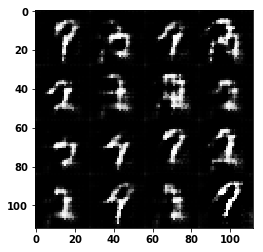

Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.4452... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.6371
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.6968


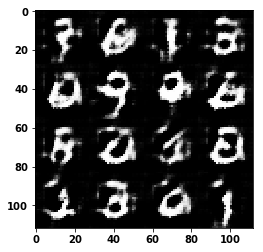

Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.8940
Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 0.6782


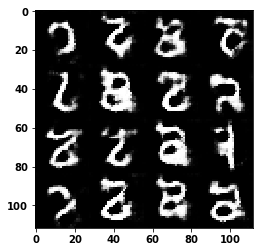

Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 1.3627... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.4807... Generator Loss: 0.6297


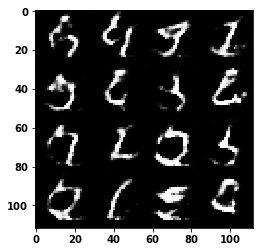

Epoch 1/2... Discriminator Loss: 1.3594... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 1.3391... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 1.4460... Generator Loss: 0.7456


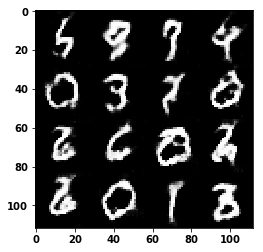

Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.7786
Epoch 1/2... Discriminator Loss: 1.3860... Generator Loss: 0.9218
Epoch 1/2... Discriminator Loss: 1.4363... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.3969... Generator Loss: 0.5250


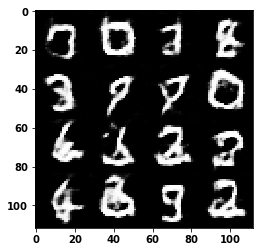

Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 1.4920... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.9395


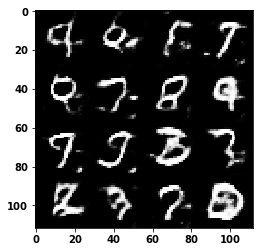

Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.7827
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.4067... Generator Loss: 0.5431


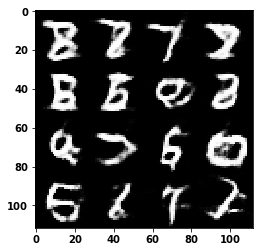

Epoch 1/2... Discriminator Loss: 1.3281... Generator Loss: 0.7098
Epoch 1/2... Discriminator Loss: 1.3247... Generator Loss: 0.5943
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 1.3485... Generator Loss: 0.7867


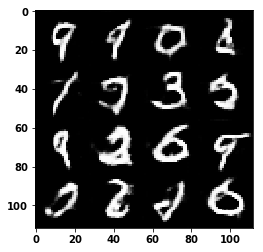

Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.3543... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.5917... Generator Loss: 1.2186
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.7526


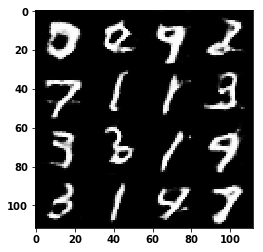

Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 1.3328... Generator Loss: 0.8796
Epoch 2/2... Discriminator Loss: 1.3531... Generator Loss: 0.8474


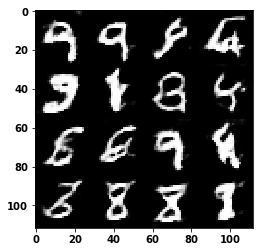

Epoch 2/2... Discriminator Loss: 1.5302... Generator Loss: 0.4587
Epoch 2/2... Discriminator Loss: 1.4042... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.7705
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.5837


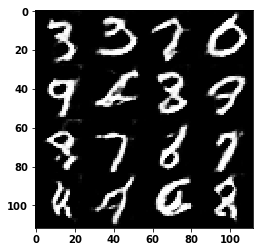

Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.5827
Epoch 2/2... Discriminator Loss: 1.5459... Generator Loss: 0.8722
Epoch 2/2... Discriminator Loss: 1.4811... Generator Loss: 0.4518
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.5805


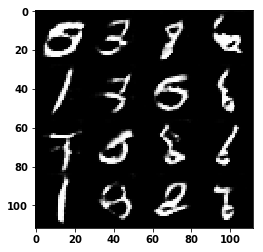

Epoch 2/2... Discriminator Loss: 1.3892... Generator Loss: 0.5562
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.6478
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7629


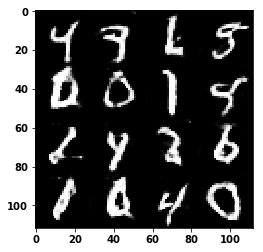

Epoch 2/2... Discriminator Loss: 1.4657... Generator Loss: 1.1256
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 0.7842


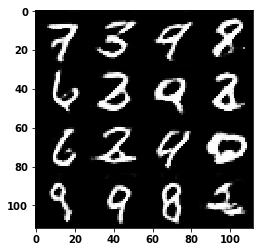

Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.6270
Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.4617


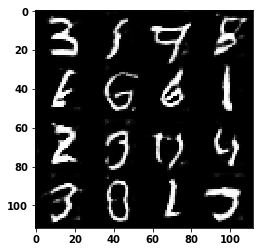

Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.5715
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.7091
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.7041


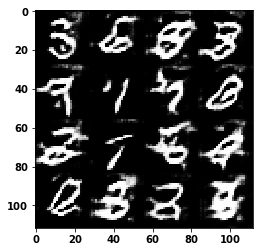

Epoch 2/2... Discriminator Loss: 1.4177... Generator Loss: 0.7129
Epoch 2/2... Discriminator Loss: 1.3837... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.7550


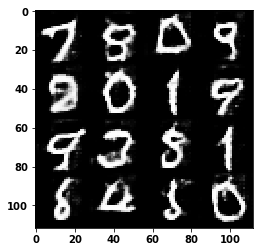

Epoch 2/2... Discriminator Loss: 1.3871... Generator Loss: 0.6872
Epoch 2/2... Discriminator Loss: 1.3963... Generator Loss: 0.6934
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.6938


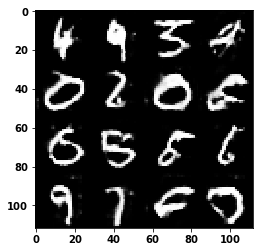

Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.6962
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.3711... Generator Loss: 0.7145
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.7066


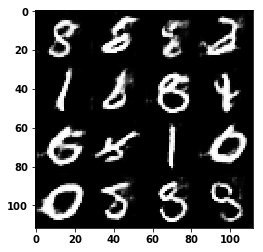

Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 0.8089
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.6661


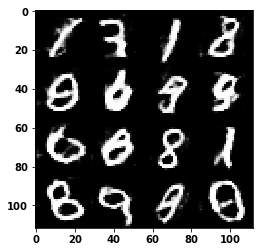

Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.7076


In [12]:
# First submission was at 64
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.4389
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.1783
Epoch 1/1... Discriminator Loss: 2.2529... Generator Loss: 1.7536


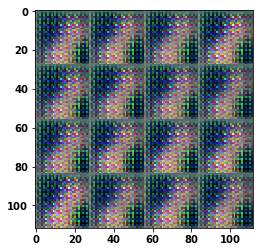

Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 1.3197
Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.0754
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 1.0950


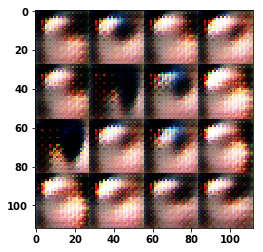

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.8754


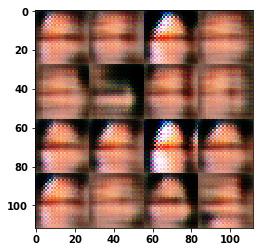

Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8512


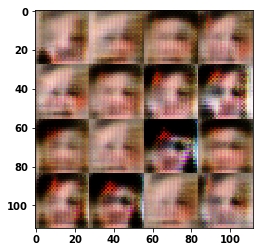

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6602


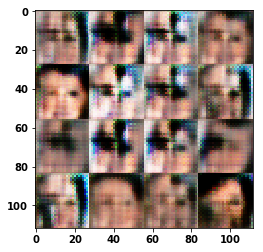

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7028


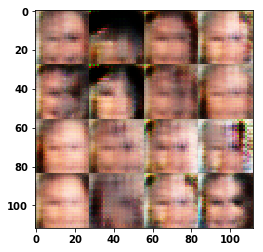

Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7867


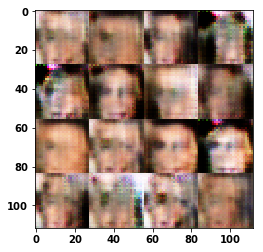

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.7412... Generator Loss: 0.9166


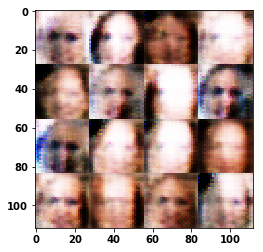

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 1.0418


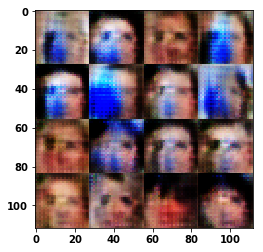

Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.7780


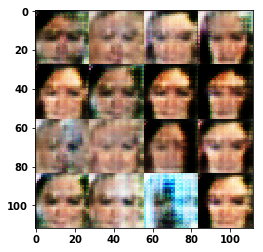

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8469


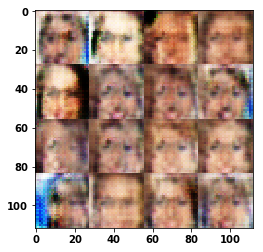

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6574


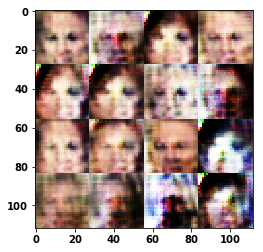

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7200


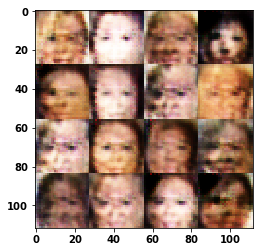

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7671


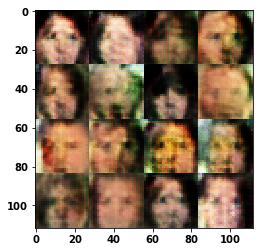

Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8177


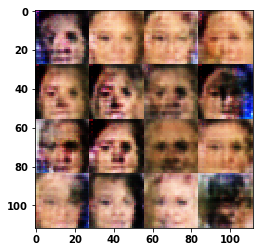

Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8033


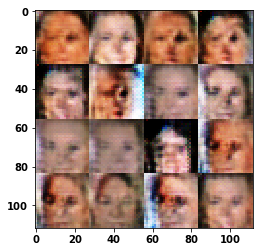

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.7412


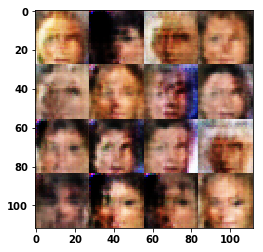

Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.8049


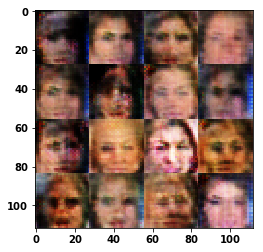

Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.2603... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.8131


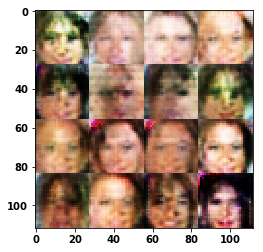

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6834


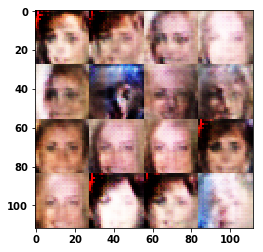

Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7236


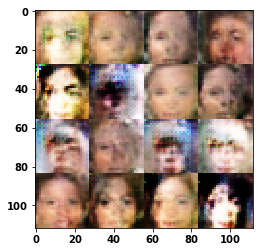

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7629


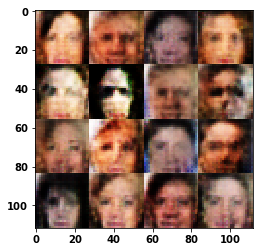

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8764


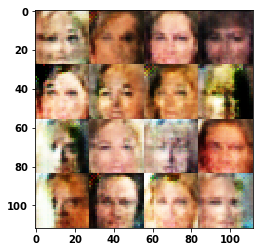

Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7680


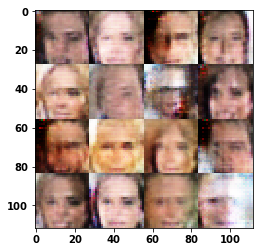

Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.6797


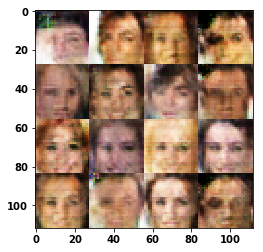

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6543


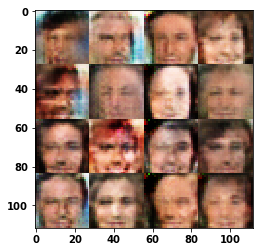

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.6653


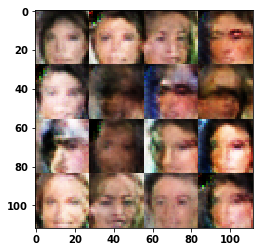

Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.7509


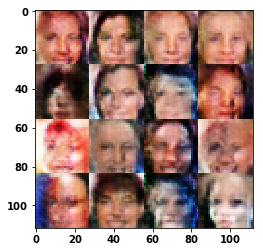

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5845


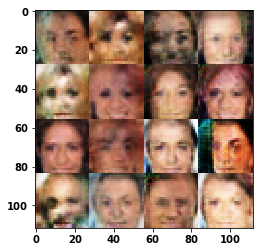

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8465


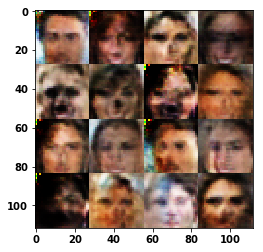

Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.7839


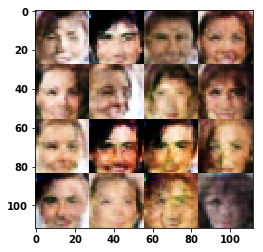

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7039


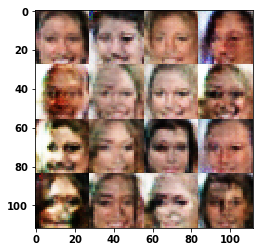

Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.8102


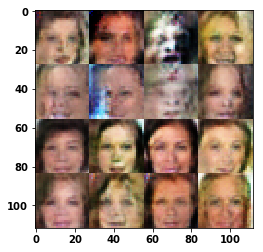

Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.8588


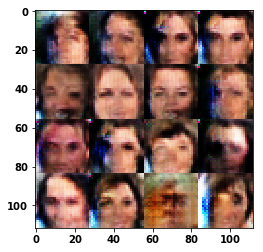

Epoch 1/1... Discriminator Loss: 1.5830... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 0.7884


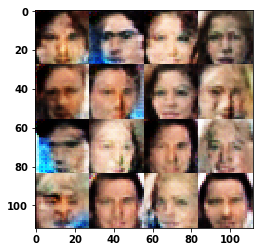

Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7238


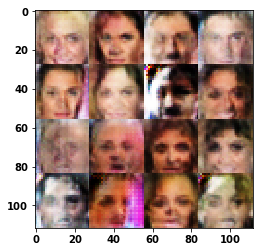

Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7255


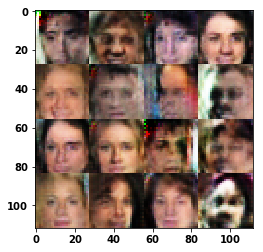

Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.8923


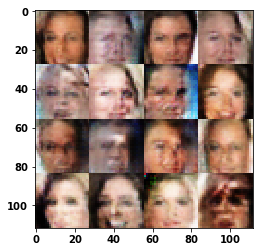

Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7248


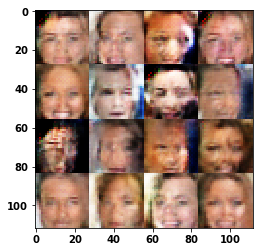

Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.6904


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.2
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.